In [1]:
import findspark
findspark.init()

import pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField,StringType,IntegerType,StructType,DateType,FloatType
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
spark = SparkSession \
    .builder \
    .appName("Proyecto") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

Se leen los datos de los accidentes

In [4]:
accidentsUSAFull = spark \
    .read \
    .format("csv") \
    .option("path", "Datos/US_Accidents_Dec21_updated_solo_2021.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("ID", StringType()),
                StructField("Severity", IntegerType()),
                StructField("Start_Time", StringType()),
                StructField("End_Time", StringType()),
                StructField("Start_Lat", FloatType()),
                StructField("Start_Lng", FloatType()),
                StructField("End_Lat", FloatType()),
                StructField("End_Lng", FloatType()),
                StructField("Distance(mi)", FloatType()),
                StructField("Description", StringType()),
                StructField("Number", IntegerType()),
                StructField("Street", StringType()),
                StructField("Side", StringType()),
                StructField("City", StringType()),
                StructField("County", StringType()),
                StructField("State", StringType()),
                StructField("Zipcode", StringType()),
                StructField("Country", StringType()),
                StructField("Timezone", StringType()),
                StructField("Airport_Code", StringType()),
                StructField("Weather_Timestamp", StringType()),
                StructField("Temperature(F)", FloatType()),
                StructField("Wind_Chill(F)", FloatType()),
                StructField("Humidity(%)", FloatType()),
                StructField("Pressure(in)", FloatType()),
                StructField("Visibility(mi)", FloatType()),
                StructField("Wind_Direction", StringType()),
                StructField("Wind_Speed(mph)", FloatType()),
                StructField("Precipitation(in)", FloatType()),
                StructField("Weather_Condition", StringType())
                ])) \
    .load()
#accidentsUSAFull.select(to_timestamp(accidentsUSAFull.Start_Time, 'MM-dd-YYYY HH:mm:ss').alias('dt')).show(1)
#accidentsUSAFull.printSchema()
accidentsUSAFull= accidentsUSAFull.withColumn('col_with_date_format',F.to_date(accidentsUSAFull.Start_Time))
#below is the result
accidentsUSAFull.select('Start_Time','col_with_date_format').show(10,False)
#accidentsUSAFull.select(to_timestamp(accidentsUSAFull.Start_Time, 'MM-dd-yyyy HH:mm').alias('dt')).collect()



+----------+--------------------+
|Start_Time|col_with_date_format|
+----------+--------------------+
|3/10/2021 |null                |
|7/30/2021 |null                |
|10/15/2021|null                |
|12/21/2021|null                |
|12/9/2021 |null                |
|9/4/2021  |null                |
|12/30/2021|null                |
|9/30/2021 |null                |
|4/1/2021  |null                |
|12/22/2021|null                |
+----------+--------------------+
only showing top 10 rows



Filtramos un poco el dataframe para solo obtener las columnas de nuestro interes

In [5]:
accidentsUSA=accidentsUSAFull.select(accidentsUSAFull["Severity"],
accidentsUSAFull["Start_Time"],accidentsUSAFull["End_Time"],accidentsUSAFull["City"],
accidentsUSAFull["County"],accidentsUSAFull["State"],accidentsUSAFull["Temperature(F)"],
accidentsUSAFull["Wind_Chill(F)"],
accidentsUSAFull["Humidity(%)"],accidentsUSAFull["Pressure(in)"],accidentsUSAFull["Visibility(mi)"],
accidentsUSAFull["Zipcode"])

Hacemos un describe de los datos

In [6]:
accidentsUSA.describe().show()

+-------+-------------------+----------+---------+----------+---------+------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|summary|           Severity|Start_Time| End_Time|      City|   County| State|   Temperature(F)|     Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)|           Zipcode|
+-------+-------------------+----------+---------+----------+---------+------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             665578|    665578|   665578|    665546|   665578|665578|           652030|            647511|            651439|            653755|           651952|            665402|
|   mean| 2.0362361736716057|      null|     null|      null|     null|  null|66.33849838197395| 65.62951054113367| 63.62939891532438| 29.38612578437885|9.154023118264934| 55796.87925271673|
| stddev|0.26675718167377094|      null|     

Contamos los valores nullos

In [7]:
from pyspark.sql.functions import col,isnan, when, count
accidentsUSA.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in accidentsUSA.columns]
   ).show()

+--------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|Severity|Start_Time|End_Time|City|County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Zipcode|
+--------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|       0|         0|       0|  32|     0|    0|         13548|        18067|      14139|       11823|         13626|    176|
+--------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+



Se limpia el dataset

In [8]:

accidentsUSA=accidentsUSA.na.drop()


In [9]:
from pyspark.sql.functions import col,isnan, when, count
accidentsUSA.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in accidentsUSA.columns]
   ).show()

+--------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|Severity|Start_Time|End_Time|City|County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Zipcode|
+--------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+
|       0|         0|       0|   0|     0|    0|             0|            0|          0|           0|             0|      0|
+--------+----------+--------+----+------+-----+--------------+-------------+-----------+------------+--------------+-------+



Se lee el archivo del clima

In [10]:
WeatherFull = spark \
    .read \
    .format("csv") \
    .option("path", "Datos/WeatherEvents_Jan2016-Dec2021_solo_2021.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("EventId", StringType()),
                StructField("Type", StringType()),
                StructField("Severity", StringType()),
                StructField("StartTime(UTC)", StringType()),
                StructField("EndTime(UTC)", StringType()),
                StructField("Precipitation(in)", FloatType()),
                StructField("TimeZone", StringType()),
                StructField("AirportCode", StringType()),
                StructField("LocationLat", FloatType()),
                 StructField("LocationLng", FloatType()),
                StructField("City", StringType()),
                StructField("County", StringType()),
                StructField("State", StringType()),
                StructField("ZipCode", StringType()),
               
                ])) \
    .load()
WeatherFull.show()

+-------+-----+--------+--------------+------------+-----------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
|EventId| Type|Severity|StartTime(UTC)|EndTime(UTC)|Precipitation(in)|   TimeZone|AirportCode|LocationLat|LocationLng|    City|  County|State|ZipCode|
+-------+-----+--------+--------------+------------+-----------------+-----------+-----------+-----------+-----------+--------+--------+-----+-------+
| W-1973| Snow|   Light|      1/6/2021|    1/6/2021|              0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
| W-1974| Snow|   Light|     1/10/2021|   1/10/2021|              0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
| W-1975|Storm|  Severe|     1/14/2021|   1/14/2021|              0.0|US/Mountain|       K04V|    38.0972|  -106.1689|Saguache|Saguache|   CO|  81149|
| W-1976|Storm|  Severe|     1/14/2021|   1/14/2021|              0.0|US/Mountain|       K04V|

Simplificamos el dataset con lo que necesitamos

In [11]:
weatherUSA=WeatherFull.select(WeatherFull["Type"],
WeatherFull["Severity"],WeatherFull["StartTime(UTC)"],WeatherFull["EndTime(UTC)"],
WeatherFull["Precipitation(in)"],WeatherFull["State"],WeatherFull["County"],
WeatherFull["City"],
WeatherFull["Zipcode"])

In [12]:
weatherUSA.describe().show()

+-------+------+--------+--------------+------------+-------------------+------+-------------+--------+------------------+
|summary|  Type|Severity|StartTime(UTC)|EndTime(UTC)|  Precipitation(in)| State|       County|    City|           Zipcode|
+-------+------+--------+--------------+------------+-------------------+------+-------------+--------+------------------+
|  count|168132|  168132|        168132|      168132|             168132|168132|       168132|  167276|            166132|
|   mean|  null|    null|          null|        null|0.08292591528754716|  null|         null|    null| 52135.55378253437|
| stddev|  null|    null|          null|        null| 0.5147711528937678|  null|         null|    null|26458.947353143405|
|    min|  Cold|   Heavy|      1/1/2021|    1/1/2021|                0.0|    AL|      Alamosa|Abingdon|             10024|
|    max| Storm|     UNK|      9/9/2021|    9/9/2021|             105.58|    WY|Zapata County|  Zapata|             99362|
+-------+------+

In [13]:
weatherUSA.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in weatherUSA.columns]
   ).show()

+----+--------+--------------+------------+-----------------+-----+------+----+-------+
|Type|Severity|StartTime(UTC)|EndTime(UTC)|Precipitation(in)|State|County|City|Zipcode|
+----+--------+--------------+------------+-----------------+-----+------+----+-------+
|   0|       0|             0|           0|                0|    0|     0| 856|   2000|
+----+--------+--------------+------------+-----------------+-----+------+----+-------+



Se limpia el dataset

In [14]:
weatherUSA=weatherUSA.na.drop()

In [15]:
weatherUSA.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in weatherUSA.columns]
   ).show()

+----+--------+--------------+------------+-----------------+-----+------+----+-------+
|Type|Severity|StartTime(UTC)|EndTime(UTC)|Precipitation(in)|State|County|City|Zipcode|
+----+--------+--------------+------------+-----------------+-----+------+----+-------+
|   0|       0|             0|           0|                0|    0|     0|   0|      0|
+----+--------+--------------+------------+-----------------+-----+------+----+-------+



EDA

<AxesSubplot:>

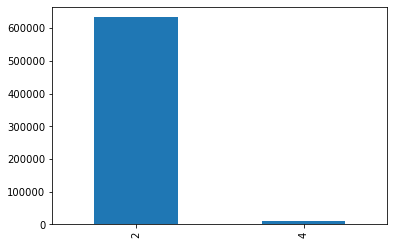

In [16]:
x=accidentsUSA.toPandas()["Severity"].values.tolist()

pd.Series(x).value_counts(sort=False).plot(kind='bar')



644494


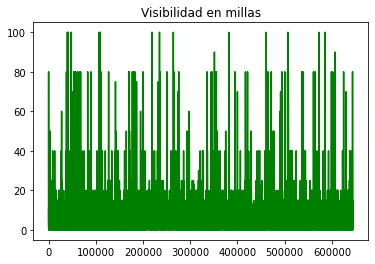

In [27]:

y=accidentsUSA.toPandas()["Visibility(mi)"].values.tolist()
x = np.arange(0, len(y))
print(len(y))
plt.title("Visibilidad en millas")

plt.plot(x, y, color ="green")
plt.show()

<AxesSubplot:>

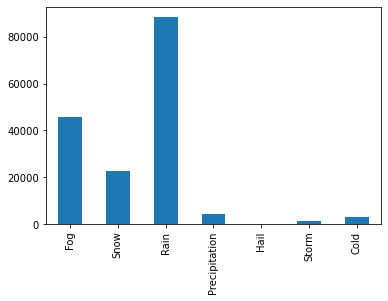

In [28]:
x=weatherUSA.toPandas()["Type"].values.tolist()

pd.Series(x).value_counts(sort=False).plot(kind='bar')

<AxesSubplot:>

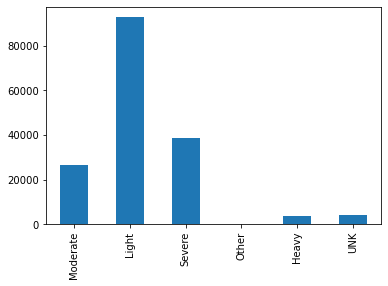

In [29]:
x=weatherUSA.toPandas()["Severity"].values.tolist()

pd.Series(x).value_counts(sort=False).plot(kind='bar')